# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

In [ ]:
!pip install -q kaggle
import json
# from google.colab import files

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score, accuracy_score,\
    classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import scatter_matrix
import warnings
warnings.filterwarnings('ignore')

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [ ]:
k = {"username":"nicolasmengochea",
     "key":"c93cfa7017ca4c7082e7bb521ec99ecc"}
with open('kaggle.json', 'w') as fp:
  json.dump(k, fp)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk
!mkdir home-credit-default-risk
!unzip home-credit-default-risk.zip -d home-credit-default-risk

### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [4]:
application_test = pd.read_csv('DataSets/application_test.csv')
application_train = pd.read_csv('DataSets/application_train.csv')

In [9]:
print(application_train.info())
print('--------------------------')
print(application_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


2- List all columns in the train dataset

In [17]:
for column in application_train:
    if column not in application_test.columns:
        print(f"Missing column: ", column)
print('--------------------------------------------------------------------------------------')
print(list(application_train.columns))

Missing column:  TARGET
--------------------------------------------------------------------------------------
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',

3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [18]:
a = application_train.head(5)
a = a.T
a

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_MON,0.0,0.0,0.0,NaN,0.0
AMT_REQ_CREDIT_BUREAU_QRT,0.0,0.0,0.0,NaN,0.0


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

0    282686
1     24825
Name: TARGET, dtype: int64


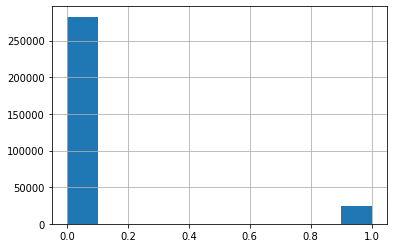

In [23]:
application_train['TARGET'].hist()
print(application_train['TARGET'].value_counts())


([<matplotlib.patches.Wedge at 0x1bf8036b6d0>,
 [Text(-1.0648123216659293, 0.27599768047650985, 'Negative'),
  Text(1.0648123152057372, -0.27599770540024077, 'Positive')],
 [Text(-0.5808067209086887, 0.15054418935082356, '92%'),
  Text(0.5808067173849475, -0.15054420294558588, '8%')])

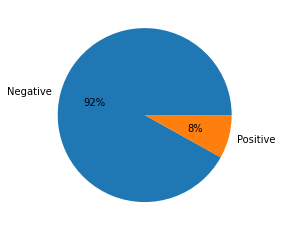

In [24]:
plt.pie(application_train['TARGET'].value_counts(), labels=['Negative','Positive'], autopct='%.0f%%')

5- Show the number of columns of each data type

In [27]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

6- For categorical variables, show the number of distinct values in each column (number of labels)

In [40]:
application_train['NAME_TYPE_SUITE'].nunique()

7

In [41]:
cat_quant_variables = {}
cat_variables = {}
for column in application_train.columns:
    if application_train[column].dtype == 'object':
        cat_quant_variables.update({column:application_train[column].value_counts()})
        cat_variables.update({column: application_train[column].nunique()})

cat_quant_variables

{'NAME_CONTRACT_TYPE': Cash loans         278232
 Revolving loans     29279
 Name: NAME_CONTRACT_TYPE, dtype: int64,
 'CODE_GENDER': F      202448
 M      105059
 XNA         4
 Name: CODE_GENDER, dtype: int64,
 'FLAG_OWN_CAR': N    202924
 Y    104587
 Name: FLAG_OWN_CAR, dtype: int64,
 'FLAG_OWN_REALTY': Y    213312
 N     94199
 Name: FLAG_OWN_REALTY, dtype: int64,
 'NAME_TYPE_SUITE': Unaccompanied      248526
 Family              40149
 Spouse, partner     11370
 Children             3267
 Other_B              1770
 Other_A               866
 Group of people       271
 Name: NAME_TYPE_SUITE, dtype: int64,
 'NAME_INCOME_TYPE': Working                 158774
 Commercial associate     71617
 Pensioner                55362
 State servant            21703
 Unemployed                  22
 Student                     18
 Businessman                 10
 Maternity leave              5
 Name: NAME_INCOME_TYPE, dtype: int64,
 'NAME_EDUCATION_TYPE': Secondary / secondary special    218391
 Hig

In [42]:
cat_variables

{'NAME_CONTRACT_TYPE': 2,
 'CODE_GENDER': 3,
 'FLAG_OWN_CAR': 2,
 'FLAG_OWN_REALTY': 2,
 'NAME_TYPE_SUITE': 7,
 'NAME_INCOME_TYPE': 8,
 'NAME_EDUCATION_TYPE': 5,
 'NAME_FAMILY_STATUS': 6,
 'NAME_HOUSING_TYPE': 6,
 'OCCUPATION_TYPE': 18,
 'WEEKDAY_APPR_PROCESS_START': 7,
 'ORGANIZATION_TYPE': 58,
 'FONDKAPREMONT_MODE': 4,
 'HOUSETYPE_MODE': 3,
 'WALLSMATERIAL_MODE': 7,
 'EMERGENCYSTATE_MODE': 2}

7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [44]:
application_train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [60]:
missing_values = pd.DataFrame(application_train.isna().sum() / application_train.count().max(), columns=['data'])
missing_values.sort_values('data', ascending=False, inplace=True)
missing_values.head(20)

,data
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MODE,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550


**Analyzing distribution of variables**

1- Show the distribution of credit amounts

<AxesSubplot:>

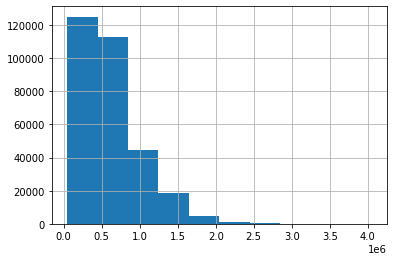

In [61]:
application_train['AMT_CREDIT'].hist()

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

In [ ]:
### Complete in this cell: level of education plot

3- Plot the distribution of ocupation of the loan applicants

In [ ]:
### Complete in this cell: ocupation of applicants

4- Plot the family status of the applicants

In [ ]:
### Complete in this cell: family status

5- Plot the income type of applicants grouped by the target variable

In [ ]:
### Complete in this cell: Income type of applicants by target variable

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [ ]:
### Complete in this cell: Data pre processing function    

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [ ]:
### Complete in this cell: train a logistic regression 

2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [ ]:
### Complete in this cell: predict test data and save csv

3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

At this point, the model should produce a result around 0.67 

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
### Complete in this cell: train a RandomForestClassifier

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
### Complete in this cell: predict test data and save csv

3- Load the predictions to the competition. Report the private score here.

In [ ]:
### Complete in this cell: report your score on Kaggle
# This model should have a private score around 0.68 

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

In [ ]:
### Complete in this cell: Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier
example_hyperparameter_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200]
}

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
### Complete in this cell: predict test data and save csv

3- Load the predictions to the competition. Report the private score here.

In [ ]:
### Complete in this cell: report your score on Kaggle
# This model should have a private score around 0.70 

4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
### Complete in this cell: train a LightGBM model


### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [ ]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training 